In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import string
from math import ceil
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple

fontsize = 11
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rcParams['text.usetex'] = False

blue, orange, purple, green, red, brown = '#3b4f8b', '#F07A00', '#83639f', '#8ADFBE', '#D7281A', '#C6826B'
yellow = '#f2a36e'#'#fbb45d'#'#EDB073'

colors = {
    'edge': None,
    'line': 'black',
    'S-OEE': '#1f77b4',
    'FGP-rOEE': '#ff7f0e',
    'WBCP': '#2ca02c',
    'P-DQC (PA)': '#660e60',
    'P-DQC (CE)': '#c7522a',
    'AutoComm': '#03dbfc',
    'DQTetris': 'r',
}

file = 'data.xlsx'

# Mergeable Depth Threshold

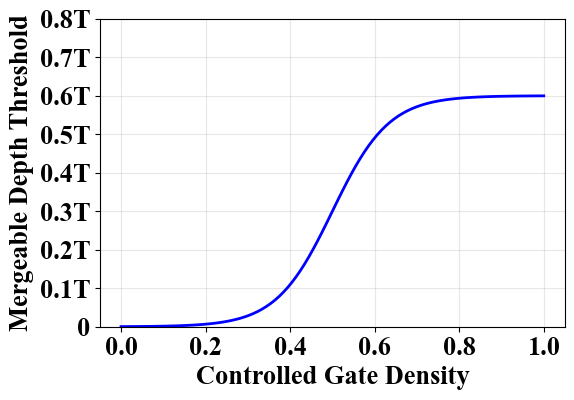

In [2]:
def sigmoid_decay(gate_density, depth, k=15, c=0.5):
    return 0.6 * depth * (1 - 1 / (1 + np.exp(-k * (gate_density - c))))

def sigmoid_increase(gate_density, depth, k=15, c=0.5):
    return 0.6 * depth * (1 / (1 + np.exp(-k * (gate_density - c))))

depth = 1
k = 15
c = 0.5
gate_densities = np.linspace(0, 1, 100)
min_depth = [sigmoid_increase(gd, depth, k, c) for gd in gate_densities]

offset = 8
plt.figure(figsize=(6, 4))
plt.plot(gate_densities, min_depth, label=f'k={k}, c={c}', color='blue', linewidth=2)
plt.xlabel("Controlled Gate Density", fontweight='bold', fontsize=fontsize+offset)
plt.ylabel("Mergeable Depth Threshold", fontweight='bold', fontsize=fontsize+offset)
# 设置纵坐标范围
plt.ylim(0, 0.8)
# 设置纵坐标标签
ylabels = [f'{i/10}T' for i in range(9)]
ylabels[0] = '0'
plt.xticks(np.arange(0, 1.1, 0.2), fontweight='bold', fontsize=fontsize+offset)
plt.yticks(np.linspace(0, 0.8, 9), ylabels, fontweight='bold', fontsize=fontsize+offset)
plt.grid(True, alpha=0.3)
plt.savefig('sigmoid_increase.pdf', format='pdf', bbox_inches='tight')
plt.show()

# QV

## 10 qubits/module

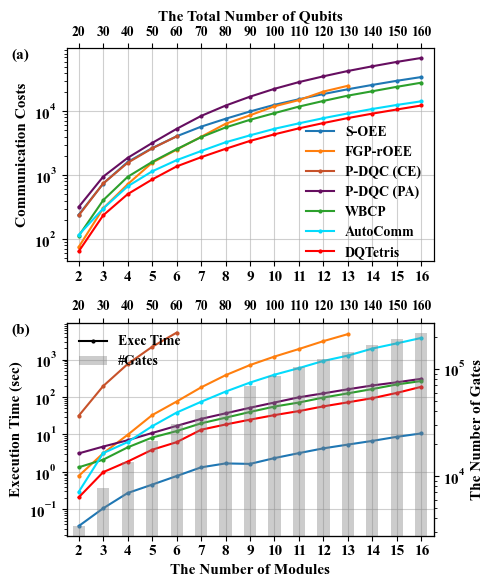

In [3]:
# 读取 Excel 文件中的 qv_10 工作表
file_path = file  # 请替换为实际的文件路径
sheetname = 'qv_10'
xticks = np.arange(2, 17, 1)
df = pd.read_excel(file_path, sheet_name=sheetname)

# 获取 Metrics 列的索引
metrics_index = df.columns.get_loc('Metrics')
# 获取 Metrics 后面的列名
methods = df.columns[metrics_index + 1:]

# 创建一个包含两个子图的图形
fig, axes = plt.subplots(2, 1, figsize=(5.1, 6), sharex=False)

# 子图 a：纵坐标为 Comm Costs 及 Metrics 后面的列
comm_costs_df = df[df['Metrics'] == 'Comm Costs']
for idx, col in enumerate(methods):
    axes[0].plot(comm_costs_df['#Modules'], comm_costs_df[col], label=col, color=colors[col], marker='.', markersize=4)

# axes[0].set_xlabel('The Number of Modules', fontweight='bold', fontsize=fontsize)
axes[0].set_ylabel('The Number of Gates', fontweight='bold', fontsize=fontsize)
axes[0].set_ylabel('Communication Costs', fontweight='bold')
axes[0].set_yscale('log')
axes[0].legend(fontsize=fontsize-1, loc='lower right', 
               frameon=False, bbox_to_anchor=(1, -0.05))
axes[0].set_xlim(1.5, 16.5)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([f'{m:.0f}' for m in xticks])
axes[0].grid(True, alpha=0.6)

axes_nqubit = axes[0].twiny()
# 设置副X轴的范围与主X轴一致
axes_nqubit.set_xlim(axes[0].get_xlim())
# 设置副X轴的刻度和标签
axes_nqubit.set_xticks(xticks)  # 使用与主X轴相同的刻度位置
axes_nqubit.set_xticklabels([f'{nq:.0f}' for nq in comm_costs_df['#Qubits']], fontsize=fontsize-1.2)
axes_nqubit.set_xlabel('The Total Number of Qubits', fontweight='bold', fontsize=fontsize)

# 子图 b：纵坐标为 Exec Time 及 Metrics 后面的列
exec_time_df = df[df['Metrics'] == 'Exec Time']
for idx, col in enumerate(methods):
    axes[1].plot(exec_time_df['#Modules'], exec_time_df[col], 
                    color=colors[col], marker='.', markersize=4)

axes[1].set_xlabel('The Number of Modules', fontweight='bold', fontsize=fontsize)
axes[1].set_ylabel('Execution Time (sec)', fontweight='bold', fontsize=fontsize)
axes[1].set_yscale('log')
axes[1].set_xlim(1.5, 16.5)
axes[1].set_xticks(xticks)
axes[1].grid(True, alpha=0.6)

# 在子图b上添加柱状图（使用右边的坐标轴）
ax2 = axes[1].twinx()
gates_data = df[df['Metrics'] == 'Comm Costs']['#Gates'].unique()
ax2.bar(exec_time_df['#Modules'], gates_data, width=0.5, alpha=0.4, color='gray', label='#Gates')
ax2.set_ylabel('The Number of Gates', fontweight='bold', fontsize=fontsize)
ax2.set_yscale('log')

axes1_nqubit = axes[1].twiny()
# 设置副X轴的范围与主X轴一致
axes1_nqubit.set_xlim(axes[1].get_xlim())
# 设置副X轴的刻度和标签
axes1_nqubit.set_xticks(exec_time_df['#Modules'])  # 使用与主X轴相同的刻度位置
axes1_nqubit.set_xticklabels([f'{nq:.0f}' for nq in exec_time_df['#Qubits']], fontsize=fontsize-1.2)
# axes1_nqubit.set_xlabel('The Total Number of Qubits', fontweight='bold', fontsize=fontsize)

# 在子图左边写(a)和(b)的标签
for i, ax in enumerate(axes):
    ax.text(-0.15, 0.95, f'({string.ascii_lowercase[i]})', transform=ax.transAxes, fontsize=fontsize, fontweight='bold')

# 创建代表 Time 的线条图例
time_line = Line2D([0], [0], color='black', label='Time', marker='.', markersize=4)

# 合并图例
# lines, labels = axes[1].get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
axes[1].legend([time_line] + bars, ['Exec Time'] + bar_labels, fontsize=fontsize-1, loc='upper left', frameon=False)

# 调整子图布局
plt.tight_layout()
plt.savefig(f'{sheetname}.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 50 qubits/module 100-350

C:\Users\Man\AppData\Local\Temp\ipykernel_24424\1893557016.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_costs_df[methods] /= scale
C:\Users\Man\AppData\Local\Temp\ipykernel_24424\1893557016.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec_time_df[methods] /= 60


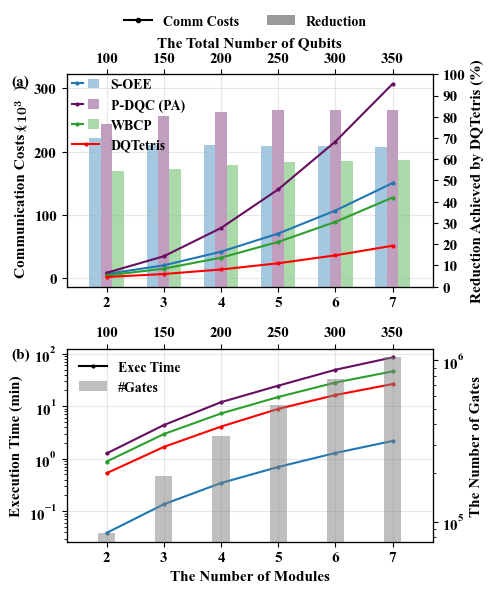

In [4]:
# 读取 Excel 文件中的 qv_50 工作表
file_path = file
sheetname = 'qv_50'
df = pd.read_excel(file_path, sheet_name=sheetname)

# 获取 Metrics 列的索引
metrics_index = df.columns.get_loc('Metrics')
# 获取 Metrics 后面的列名
methods = df.columns[metrics_index + 1:]

# 筛选出 Metrics 列为 Comm Costs 的数据
comm_costs_df = df[df['Metrics'] == 'Comm Costs']
scale = 1000
# 将 Comm Costs 列的数据除以 scale
comm_costs_df[methods] /= scale

# 创建画布，包含两个子图
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(5.1, 5.8), gridspec_kw={'height_ratios': [1.1, 1]})

# 子图(a)的设置
ax1.set_zorder(10)
ax1.patch.set_visible(False)

# 创建第二个 y 轴
ax2 = ax1.twinx()
ax2.set_zorder(5)
ax2.patch.set_visible(False)

# 用于存储所有方法的句柄和标签
all_handles = []
all_labels = []

for idx, col in enumerate(methods):
    line, = ax1.plot(comm_costs_df['#Modules'], comm_costs_df[col], label=col,
                     color=colors[col], marker='.', markersize=4)
    if col!= 'DQTetris':
        # 计算 DQTetris 与其他方法相比的 reduction 百分比
        reduction = ((comm_costs_df[col] - comm_costs_df['DQTetris']) / comm_costs_df[col]) * 100

        # 设置柱子的宽度
        width = 0.2

        bar = ax2.bar(comm_costs_df['#Modules'] - width + idx * width, reduction, width, label=col,
                      alpha=0.4, color=colors[col])
        # 将折线和柱子的句柄组合在一起
        all_handles.append([line, bar])
    else:
        all_handles.append([line])
    all_labels.append(col)

# 设置子图(a)坐标轴标签和标题
# ax1.set_xlabel('The Number of Modules', fontsize=fontsize, fontweight='bold')
ax1.set_xlim(1.3, 7.7)
ax1.set_xticks(comm_costs_df['#Modules'])
ax1_up = ax1.twiny()
# 设置副X轴的范围与主X轴一致
ax1_up.set_xlim(ax1.get_xlim())
# 设置副X轴的刻度和标签
ax1_up.set_xticks(comm_costs_df['#Modules'])  # 使用与主X轴相同的刻度位置
ax1_up.set_xticklabels([f'{nq:.0f}' for nq in comm_costs_df['#Qubits']], fontsize=fontsize)
ax1_up.set_xlabel('The Total Number of Qubits', fontweight='bold', fontsize=fontsize)

ax1.set_ylabel('Communication Costs (         )', fontsize=fontsize, fontweight='bold')
ax1.text(-0.14, 0.89, r'$\mathbf{\times 10^3}$', fontsize=fontsize-1, rotation=90,
         fontweight='bold', usetex=True, ha='left', va='top', transform=ax1.transAxes)
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.3)

# 设置子图(a)第二个 y 轴的标签
ax2.set_ylabel('Reduction Achieved by DQTetris (%)', fontsize=fontsize, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_yticks(np.arange(0, 101, 10))

# 处理子图(a)图例中句柄的显示方式，使其左右并列
ax2.legend([tuple(handles) for handles in all_handles], all_labels,
           loc='upper left', 
           bbox_to_anchor=(-0.02, 1.04),
           fontsize=fontsize - 1, frameon=False,
           handler_map={tuple: HandlerTuple(ndivide=None)})

# 创建子图(a)新的图例元素
line_sample = Line2D([0], [0], color='black', marker='.', label='Comm Costs')
rectangle_sample = Rectangle((0, 0), 1, 1, facecolor='black', alpha=0.4, label='Reduction')

# 在子图(a)的上方中间添加新的图例
fig.legend(handles=[line_sample, rectangle_sample], 
           loc='upper center',
           bbox_to_anchor=(0.5, 1.03),
           ncol=2, fontsize=fontsize - 1, frameon=False)

# 筛选出 Metrics 列为 Exec Time 的数据
exec_time_df = df[df['Metrics'] == 'Exec Time']
# 将 exec time 列的数据除以 60 换算成分钟
exec_time_df[methods] /= 60

# 子图(b)的绘制
for col in methods:
    ax3.semilogy(exec_time_df['#Modules'], exec_time_df[col], label=col,
                 color=colors[col], marker='.', markersize=4)

# 设置子图(b)坐标轴标签和标题
ax3.set_xlim(1.3, 7.7)
ax3.set_xticks(comm_costs_df['#Modules'])
ax3_up = ax3.twiny()
# 设置副X轴的范围与主X轴一致
ax3_up.set_xlim(ax3.get_xlim())
# 设置副X轴的刻度和标签
ax3_up.set_xticks(comm_costs_df['#Modules'])  # 使用与主X轴相同的刻度位置
ax3_up.set_xticklabels([f'{nq:.0f}' for nq in comm_costs_df['#Qubits']], fontsize=fontsize)
# ax3_up.set_xlabel('The Total Number of Qubits', fontweight='bold', fontsize=fontsize)

ax3.set_xlabel('The Number of Modules', fontsize=fontsize, fontweight='bold')
ax3.set_ylabel('Execution Time (min)', fontsize=fontsize, fontweight='bold')
ax3.tick_params(axis='y')
ax3.grid(True, alpha=0.3)

# 设置子图(b)图例
# ax3.legend(loc='upper left', bbox_to_anchor=(-0.02, 1.04),
#            fontsize=fontsize - 1, frameon=False)

ax4 = ax3.twinx()
gates_data = df[df['Metrics'] == 'Comm Costs']['#Gates'].unique()
ax4.bar(comm_costs_df['#Modules'], gates_data, width=0.3, alpha=0.5, color='gray', label='#Gates')
ax4.set_ylabel('The Number of Gates', fontweight='bold', fontsize=fontsize)
ax4.set_yscale('log')
# ax4.legend(loc='upper left', fontsize=fontsize, frameon=False)

# 创建代表 Time 的线条图例
time_line = Line2D([0], [0], color='black', label='Time', marker='.', markersize=4)

# 获取 ax3 和 ax4 原有的图例句柄和标签
handles_ax3, labels_ax3 = ax3.get_legend_handles_labels()
handles_ax4, labels_ax4 = ax4.get_legend_handles_labels()

# 合并句柄和标签，并添加 Time 图例
combined_handles = [time_line] + handles_ax4 # + handles_ax3
combined_labels = ['Exec Time'] + labels_ax4 # + labels_ax3

# 创建合并后的图例
ax4.legend(combined_handles, combined_labels, loc='upper left', fontsize=fontsize-1, frameon=False)

ax1.text(-0.15, 0.95, f'({string.ascii_lowercase[0]})', transform=ax1.transAxes, fontsize=fontsize, fontweight='bold')
ax3.text(-0.15, 0.95, f'({string.ascii_lowercase[1]})', transform=ax3.transAxes, fontsize=fontsize, fontweight='bold')

# 显示图形
plt.tight_layout()
plt.savefig(f'{sheetname}.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 200 qubits in total

[100, 68, 50, 40, 34, 30, 26, 24, 20]


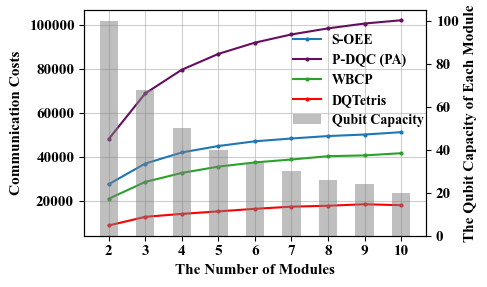

In [5]:
# 读取 Excel 文件中的 qv_200 工作表
file_path = file  # 请替换为实际的文件路径
sheetname = 'qv_200'
df = pd.read_excel(file_path, sheet_name=sheetname)

# 提取 `Comm Costs` 相关数据
comm_costs_df = df[df['Metrics'] == 'Comm Costs']

# 方法列表
# 获取 Metrics 列的索引
metrics_index = df.columns.get_loc('Metrics')
# 获取 Metrics 后面的列名
methods = df.columns[metrics_index + 1:]
# print(methods)

# 创建画布，调整子图布局
fig, ax1 = plt.subplots(figsize=(5, 3))

# 绘制折线图
for idx, col in enumerate(methods):
    ax1.plot(comm_costs_df['#Modules'], comm_costs_df[col],
             label=col, color=colors[col], marker='.', markersize=4)

# 设置 x 轴和左边 y 轴的标签和刻度
ax1.set_xticks(np.arange(2, 11, 1))
ax1.set_xlabel('The Number of Modules', fontweight='bold', fontsize=fontsize)
ax1.set_ylabel('Communication Costs', fontweight='bold', fontsize=fontsize)

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 计算柱状图的数值
qubit_capacity = []
for _, row in comm_costs_df.iterrows():
    qubit_capacity.append(ceil(row['#Qubits'] / row['#Modules']) + ceil(row['#Qubits'] / row['#Modules']) % 2)
print(qubit_capacity)

# 绘制柱状图
bars = ax2.bar(comm_costs_df['#Modules'], qubit_capacity, width=0.5, color='gray', alpha=0.5, label='Qubit Capacity')
ax2.set_ylabel('The Qubit Capacity of Each Module', fontweight='bold', fontsize=fontsize)

# 获取 ax1 和 ax2 的图例句柄和标签
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# 合并图例句柄和标签
all_lines = lines1 + lines2
all_labels = labels1 + labels2

# 添加合并后的图例
ax1.legend(all_lines, all_labels, loc='upper right', 
           bbox_to_anchor=(1.03, 0.95),
           fontsize=fontsize - 1, frameon=False)

# 添加网格线
ax1.grid(True, alpha=0.6)

plt.tight_layout()
plt.savefig(f'{sheetname}.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Different Benchmarks

In [6]:
# 读取 Excel 文件
excel_file = pd.ExcelFile(file)

# 获取指定工作表中的数据
sheetname = 'diff'
df = excel_file.parse(sheetname)

# 删除 #Modules 列
df = df.drop('#Modules', axis=1)

# 获取 Metrics 列的索引
metrics_index = df.columns.get_loc('Metrics')
# 获取 Metrics 后面的列名
methods = df.columns[metrics_index + 1:]

# 提取出 Comm Costs 和 Exec Time 相关的数据
selected_df = df[df['Metrics'].isin(['Comm Costs', 'Exec Time'])]
# print(selected_df)
# print(selected_df[selected_df['Metrics'] == 'Comm Costs'])

# 构建 Comm Costs reduction 数据
comm_costs_df = selected_df[selected_df['Metrics'] == 'Comm Costs']
exec_time_df = selected_df[selected_df['Metrics'] == 'Exec Time']

reduction_df = comm_costs_df.copy()
reduction_df['Metrics'] = 'Reduction'
for col in methods[:-1]: # ['S-OEE', 'FGP-rOEE', 'WBCP', 'Pytket-DQC', 'AutoComm']:
    reduction_df[col] = ((comm_costs_df[col] - comm_costs_df['DQTetris']) / comm_costs_df[col]).round(6)
reduction_df['DQTetris'] = '-'

for col in methods:
    exec_time_df.loc[:, col] = (exec_time_df[col] / 60).round(2)

# 将数据按要求合并
result_df = pd.concat([
    # selected_df[selected_df['Metrics'] == 'Comm Costs'], 
    comm_costs_df,
    reduction_df, 
    exec_time_df,
]) # .sort_values(by=['Circuit', '#Qubits'])

# 自定义 Circuit 的顺序
circuit_order = ['Random', 'QNN', 'Multiplier', 'Ising', 'QFT Adder']
result_df['Circuit'] = pd.Categorical(result_df['Circuit'], categories=circuit_order, ordered=True)
# 按自定义的 Circuit 顺序和 #Qubits 列进行排序
result_df = result_df.sort_values(by=['Circuit', '#Qubits'])

# print(result_df)
print(result_df.to_csv(sep=',', na_rep='nan', lineterminator='\n'))
# # 保存为 CSV 文件
# csv_path = '/mnt/processed_data.csv'
# result_df.to_csv(csv_path, index=False)

,Circuit,#Qubits,#Depths,#Gates,Metrics,S-OEE,FGP-rOEE,WBCP,Pytket-DQC,AutoComm,DQTetris
0,Random,70,6341,78634,Comm Costs,10154.0,9098.0,6849.0,8493.0,4804.0,3408.0
0,Random,70,6341,78634,Reduction,0.664369,0.625412,0.502409,0.598728,0.290591,-
3,Random,70,6341,78634,Exec Time,0.01,5.1,0.9,0.81,3.95,6.59
4,Random,130,12479,276157,Comm Costs,42906.0,80352.0,33268.0,51840.0,20385.0,16315.0
4,Random,130,12479,276157,Reduction,0.61975,0.796956,0.509589,0.685282,0.199657,-
7,Random,130,12479,276157,Exec Time,0.09,86.31,5.77,7.62,75.4,39.24
8,QNN,130,7219,320686,Comm Costs,57612.0,47020.0,32672.0,51195.0,7700.0,4635.0
8,QNN,130,7219,320686,Reduction,0.919548,0.901425,0.858135,0.909464,0.398052,-
11,QNN,130,7219,320686,Exec Time,0.01,121.28,3.5,4.41,59.83,67.03
12,Multiplier,75,10138,24414,Comm Costs,1872.0,1821.0,1776.0,7018.0,1279.0,961.0
12,Multiplier,75,10138,24414,Reduction,0.486645,0.472268,0.458896,0.863066,0.248632,-
15,Multiplier,75,10138,24414,Exec Time,0.01,19.04,1.63,0.79,0.94,11

# Different Gate Sets

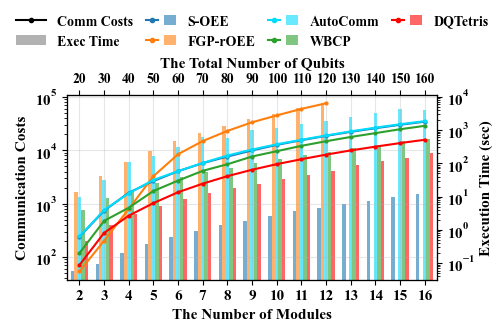

In [7]:
file_path = file  # 请替换为实际的文件路径
sheetname = 'qv_10 crz'
df = pd.read_excel(file_path, sheet_name=sheetname)

# 获取 Metrics 列的索引
metrics_index = df.columns.get_loc('Metrics')
# 获取 Metrics 后面的列名
methods = df.columns[metrics_index + 1:]

# 创建图形
fig, ax = plt.subplots(1, 1, figsize=(5.1, 4.1))

# Communication Costs ##########################

# 纵坐标为 Comm Costs 及 Metrics 后面的列
comm_costs_df = df[df['Metrics'] == 'Comm Costs']
for idx, col in enumerate(methods):
    ax.plot(comm_costs_df['#Modules'], comm_costs_df[col],
            label=col, color=colors[col], marker='.', markersize=4,
            lw=1.5,
            zorder=3)

ax.set_xlabel('The Number of Modules', fontweight='bold', fontsize=fontsize)
ax.set_ylabel('Communication Costs', fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(1.5, 16.5)
ax.set_xticks(comm_costs_df['#Modules'])
ax.set_xticklabels([f'{m:.0f}' for m in comm_costs_df['#Modules']])
ax.grid(True, alpha=0.3, zorder=0)
ax.set_facecolor('none')
ax.set_zorder(3)

# 右边的副y轴：显示每个方法的运行时间 ####################
ax2 = ax.twinx()
ax2.set_zorder(1)
ax2.set_ylabel('Execution Time (sec)', fontweight='bold', fontsize=fontsize)
ax2.set_yscale('log')

exec_time_df = df[df['Metrics'] == 'Exec Time']
# 设置柱子的宽度
width = 0.14
for idx, col in enumerate(methods):
    ax2.bar(exec_time_df['#Modules'] - 2*width + idx * width, 
            exec_time_df[col], 
            width,
            alpha=0.6, label=col, color=colors[col],
            zorder=1)

# 上面的副X轴：显示总量的量子比特数 ######################
ax_nqubit = ax.twiny()
ax_nqubit.set_zorder(3)
# 设置副X轴的范围与主X轴一致
ax_nqubit.set_xlim(ax.get_xlim())
# 设置副X轴的刻度和标签
ax_nqubit.set_xticks(comm_costs_df['#Modules'])  # 使用与主X轴相同的刻度位置
ax_nqubit.set_xticklabels([f'{nq:.0f}' for nq in comm_costs_df['#Qubits']], fontsize=fontsize-1.2)
ax_nqubit.set_xlabel('The Total Number of Qubits', fontweight='bold', fontsize=fontsize)

# --------------------------
# 自定义图例（核心修改）
# --------------------------
# 基础图例项：Comm Costs（黑色折线）和 Exec Time（灰色方块）
legend_elements = [
    (Line2D([0], [0], color='black', label='Comm Costs', marker='.'),),  # 黑色折线代表Comm Costs
    (Rectangle((0, 0), 1, 1, facecolor='gray', alpha=0.6, label='Exec Time'),)  # 灰色方块代表Exec Time
]

# 为每个method添加：彩色折线 + 彩色方块的组合图例
for col in methods:
    # 每个method的折线（短线条）和方块（对应颜色）
    # 调整line的长度
    line = Line2D([0], [0], color=colors[col], label=col, marker='.')
    square = Rectangle((0, 0), 1, 1, facecolor=colors[col], alpha=0.6)
    legend_elements.append( (line, square) )  # 组合成元组

# 图例标签：基础项 + method名称
legend_labels = ['Comm Costs', 'Exec Time'] + methods.tolist()

# 创建图例（使用HandlerTuple处理组合元素）
ax.legend(
    legend_elements,
    legend_labels,
    handler_map={tuple: HandlerTuple(ndivide=None)},  # 处理组合元素的显示
    ncol=4,  # 根据方法数量调整列数，避免过长
    fontsize=fontsize-1,
    loc='upper center',  # 顶部居中
    bbox_to_anchor=(0.5, 1.5),  # 定位在图的最上方
    frameon=False,
    columnspacing=0.9,
    handlelength=2.2
)

# 调整子图布局
plt.tight_layout()
plt.savefig(f'{sheetname}.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Sparse Networks

[100, 50, 34, 26, 20]


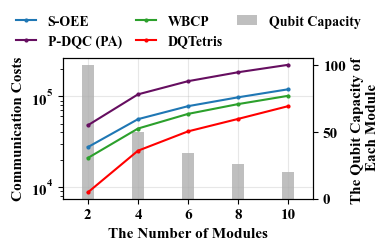

In [8]:
file_path = file  # 请替换为实际的文件路径
sheetname = 'network'
df = pd.read_excel(file_path, sheet_name=sheetname)

# 获取 Metrics 列的索引
metrics_index = df.columns.get_loc('Metrics')
# 获取 Metrics 后面的列名
methods = df.columns[metrics_index + 1:]

# 创建图形
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Communication Costs ##########################

# 纵坐标为 Comm Costs 及 Metrics 后面的列
comm_costs_df = df[df['Metrics'] == 'Comm Costs']
for idx, col in enumerate(methods):
    ax.plot(comm_costs_df['#Modules'], comm_costs_df[col],
            label=col, color=colors[col], marker='.', markersize=4,
            lw=1.5,
            zorder=3)

ax.set_xlabel('The Number of Modules', fontweight='bold', fontsize=fontsize)
ax.set_ylabel('Communication Costs', fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(1, 11)
ax.set_xticks(comm_costs_df['#Modules'])
ax.set_xticklabels([f'{m:.0f}' for m in comm_costs_df['#Modules']])
ax.grid(True, alpha=0.3, zorder=0)
ax.set_facecolor('none')
ax.set_zorder(3)

# 右边的副y轴：显示每个方法的运行时间 ####################
ax2 = ax.twinx()
ax2.set_zorder(1)
# ax2.set_ylabel('Execution Time (sec)', fontweight='bold', fontsize=fontsize)
# ax2.set_yscale('log')

# 计算柱状图的数值
qubit_capacity = []
for _, row in comm_costs_df.iterrows():
    qubit_capacity.append(ceil(row['#Qubits'] / row['#Modules']) + ceil(row['#Qubits'] / row['#Modules']) % 2)
print(qubit_capacity)

# 绘制柱状图
bars = ax2.bar(comm_costs_df['#Modules'], qubit_capacity, width=0.5, color='gray', alpha=0.5, label='Qubit Capacity')
ax2.set_ylabel('The Qubit Capacity of \n Each Module', fontweight='bold', fontsize=fontsize)

# 获取 ax1 和 ax2 的图例句柄和标签
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# 合并图例句柄和标签
all_lines = lines1 + lines2
all_labels = labels1 + labels2

# 添加合并后的图例
ax.legend(all_lines, all_labels, loc='upper center',
          bbox_to_anchor=(0.5, 1.4),
          ncol=3,
          fontsize=fontsize - 1, frameon=False,
          columnspacing=1,
          handlelength=1.5)

# 调整子图布局
plt.tight_layout()
plt.savefig(f'{sheetname}.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Average Calculation

In [9]:
# 读取 Excel 文件
excel_file = pd.ExcelFile(file)

# 获取指定工作表中的数据
sheetname = 'network'
df = excel_file.parse(sheetname)

# 筛选出 Comm Costs 相关数据
comm_costs_df = df[df['Metrics'] == 'Comm Costs']
# print(f"comm_costs_df: {comm_costs_df}")
# 筛选出 Exec Time 相关数据
exec_time_df = df[df['Metrics'] == 'Exec Time']
# print(f"exec_time_df: {exec_time_df}")

# 初始化一个空字典来存储结果
results = {}
times = {}

# 获取 Metrics 列的索引
metrics_index = df.columns.get_loc('Metrics')
# 获取 Metrics 后面的列名
methods = df.columns[metrics_index + 1:]

# 遍历除 DQTetris 外的每一种方法
for method in methods[:-1]:
    # 计算 reduction 百分比
    reduction_percentage = ((comm_costs_df[method] - comm_costs_df['DQTetris']) / comm_costs_df[method] * 100)
    # print(f"=== {method} ===\n{reduction_percentage}")

    # 计算平均 reduction 百分比
    avg_reduction_percentage = reduction_percentage.mean()
    avg_reduction_percentage = round(avg_reduction_percentage, 0)

    # 将结果存入字典
    results[method] = {
        'Average Reduction Percentage': avg_reduction_percentage
    }

for method in methods:
    avg_exec_time = exec_time_df[method].mean()
    avg_exec_time = round(avg_exec_time, 0)
    times[method] = {
        'Average Exec Time': avg_exec_time
    }

# 将结果转换为 DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
times_df = pd.DataFrame.from_dict(times, orient='index')
print(f"{sheetname}")
print(results_df)
print(times_df)

network
            Average Reduction Percentage
S-OEE                               50.0
P-DQC (PA)                          73.0
WBCP                                38.0
            Average Exec Time
S-OEE                    20.0
P-DQC (PA)              688.0
WBCP                    468.0
DQTetris                244.0


# Merge PDF

In [10]:
import pandas as pd
from PyPDF2 import PdfMerger
import os

def merge_sheet_pdfs(sheet_names):
    """
    按顺序合并对应PDF文件（工作表名+.pdf）
    """
    # 1. 初始化PDF合并器
    merger = PdfMerger()

    # 2. 按工作表顺序添加对应的PDF文件
    try:
        for sheet in sheet_names:
            pdf_file = f"{sheet}.pdf"  # 工作表名+.pdf
            if os.path.exists(pdf_file):
                merger.append(pdf_file)  # 添加PDF文件
                print(f"已添加PDF文件: {pdf_file}")
            else:
                print(f"警告: 未找到对应PDF文件 - {pdf_file}，已跳过")
    except Exception as e:
        print(f"添加PDF文件时出错: {str(e)}")
        merger.close()
        return

    # 3. 保存合并后的PDF文件
    output_file = "fig_data.pdf"
    try:
        merger.write(output_file)
        print(f"\nPDF合并完成！已保存至: {output_file}")
    except Exception as e:
        print(f"保存合并PDF失败: {str(e)}")
    finally:
        merger.close()  # 确保资源释放

# 执行合并操作
sheetnames = ['sigmoid_increase', 'qv_10', 'qv_50', 'qv_200', 'qv_10 crz', 'network']
merge_sheet_pdfs(sheetnames)

已添加PDF文件: sigmoid_increase.pdf
已添加PDF文件: qv_10.pdf
已添加PDF文件: qv_50.pdf
已添加PDF文件: qv_200.pdf
已添加PDF文件: qv_10 crz.pdf
已添加PDF文件: network.pdf

PDF合并完成！已保存至: fig_data.pdf
